In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'
    input_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/raw/'

In [2]:
from utils import data_loader

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [3]:
reduced_terms_list, df_model = data_loader(output_filepath)
df_model = df_model[df_model.year.between(1993, 2016)]
df_model.sort_values(by = 'year', inplace=True)

Text(0, 0.5, 'cumulative explained variance')

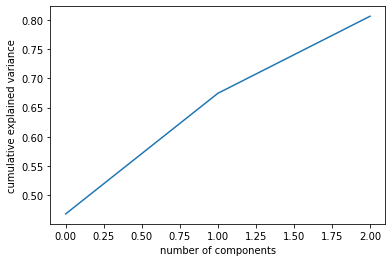

In [4]:
''' PCA '''
n = 3
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[reduced_terms_list])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[reduced_terms_list])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [5]:
def get_pvalue_grangercausalitytest(data, lag):
   
    results = grangercausalitytests(data, maxlag=[lag], verbose=0)
    
    return results[lag][0]['ssr_ftest'][1]

In [9]:
all_tests = {}
for c in df_model.country.unique():
    for lag in range(1,7):
        df_country = df_model[df_model.country == c]
        if len(df_country)>=22: 
            all_tests[(c,lag)] = [get_pvalue_grangercausalitytest(df_country[['log_gdp', 'pca_0']], lag=lag)]
            #all_tests[(c,lag)] = [get_pvalue_grangercausalitytest(df_country[['pca_0', 'log_gdp']], lag=lag)]            

In [10]:
df_granger = pd.DataFrame(all_tests).T
df_granger.reset_index(inplace=True)
df_granger.columns=['country', 'lag','pvalue']

<AxesSubplot:xlabel='lag', ylabel='pvalue'>

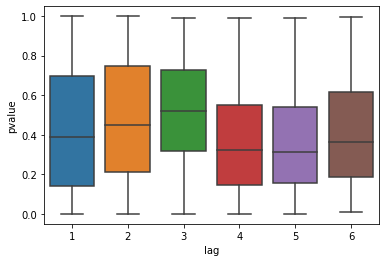

In [11]:
sns.boxplot(data=df_granger, x = 'lag', y = 'pvalue')

<AxesSubplot:xlabel='lag', ylabel='pvalue'>

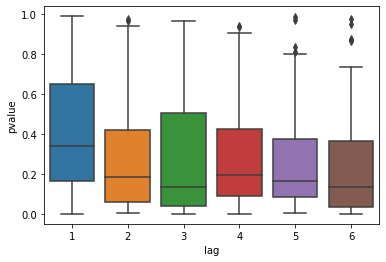

In [8]:
sns.boxplot(data=df_granger, x = 'lag', y = 'pvalue')